### First ideas:
On the abalone.csv file we'll:
- Plot the dataset through PCA reduction
- Inject errors
- Try median/mode and MICE with K-NN with median/mode
- Re-plot the dataset to see how it changed

### General imports and definitions

['0', '1', '2', '3', '4', '5', '6', '7']


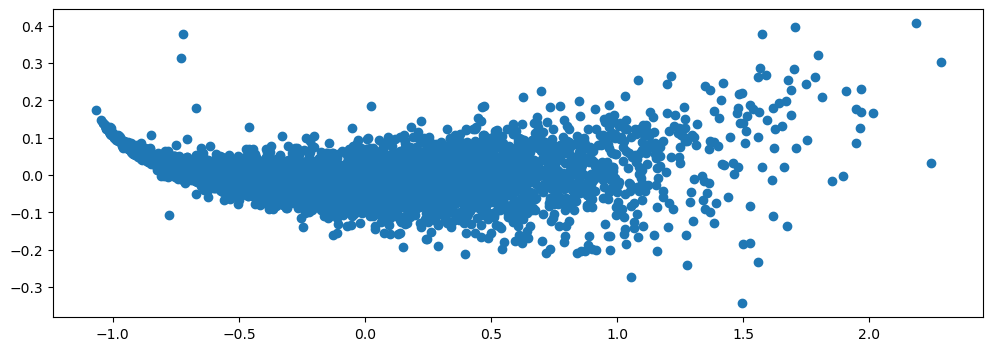

In [19]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from dirty_completeness import injection

# Load the dataset
df = pd.read_csv("../datasets/abalone.csv")
columns = list(df.columns)  # after quick inspection we see that all columns will contain missing values
print(columns)

# PCA visualization
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(df.drop('0',axis = 1))  # categorical features are dropped to allow visualization

ax.scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()

In [ ]:
# Obtain the list of null-injected datasets
perc = [0.50, 0.40, 0.30, 0.20, 0.10]
df_list = injection(df, 42, "abalone", "None")
for ds in df_list:
    display(ds)

### Single imputation: mode
Since we also have categorical features it is better to use the mode instead of the median, otherwise it would be difficult to define an ordinal order between the categorical values

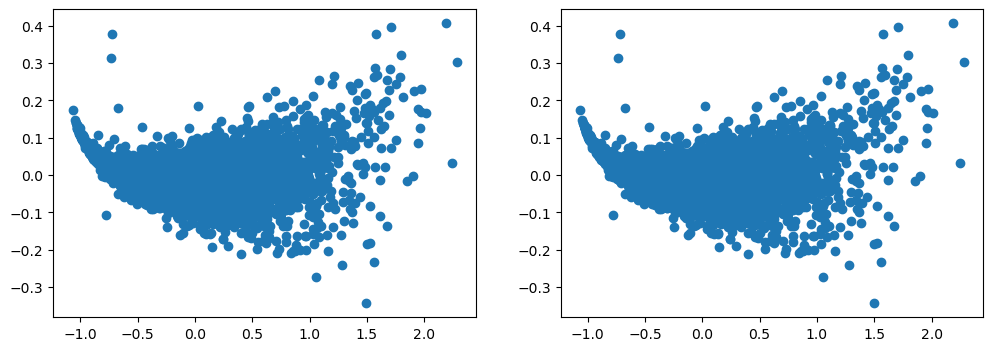

In [24]:
test_ind = 4  # must be between 0 and 4

df_test = pd.DataFrame()
for col in columns:
    df_test[col] = df[col].fillna(df[col].mode()[0])

# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(12,4))

pca = PCA(n_components=2,random_state=42)

X_pca = pca.fit_transform(df.drop('0',axis = 1))
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])

X_pca = pca.fit_transform(df_test.drop('0',axis = 1))
axes[1].scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()